In [319]:
import numpy as np
import pandas as pd
import json
import random
from itertools import chain
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [12]:
train_accounts_str = "data/train/accounts_data_train.json"
train_enquiry_str = "data/train/enquiry_data_train.json"
train_flag = "data/train/train_flag.csv"

In [29]:
test_accounts_str = "data/test/accounts_data_test.json"
test_enquiry_str = "data/test/enquiry_data_test.json"
test_flag = "data/test/test_flag.csv"

In [22]:
def load_json_files(path):
    """
    Utility function to load json files as DataFrame
    """
    with open(path) as jsonFile:
        data = json.load(jsonFile)
        json_df = pd.DataFrame(list(chain.from_iterable(data)))
        return json_df

In [249]:
train_accounts_df = load_json_files(train_accounts_str)
train_accounts_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915


In [250]:
test_accounts_df = load_json_files(test_accounts_str)
test_accounts_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,31630.50,0.0,2014-03-30,2014-11-29,000000000000000000000000,AAA14437029
1,Consumer credit,14613.39,0.0,2014-06-01,2014-11-03,000000000000000,AAA14437029
2,Credit card,54000.00,0.0,2015-12-13,2019-09-21,0000000000000000000000000000000000000000000000...,AAA14437029
3,Consumer credit,27076.50,0.0,2015-11-11,2016-11-24,000000000000000000000000000000000000,AAA14437029
4,Credit card,225000.00,0.0,2017-07-15,2019-11-14,0000000000000000000000000000000000000000000000...,AAA14437029


In [160]:
train_enquiry_df = load_json_files(train_enquiry_str)
train_enquiry_df.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248


In [31]:
test_enquiry_df = load_json_files(test_enquiry_str)
test_enquiry_df.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Car loan,143000,2020-12-13,AAA02107680
1,Real estate loan,174000,2020-12-01,AAA14437029
2,Loan for working capital replenishment,65000,2019-07-01,AAA14437029
3,Loan for working capital replenishment,118000,2020-08-05,AAA14437029
4,Car loan,12000,2020-02-28,AAA14437029


In [27]:
train_flag_df = pd.read_csv(train_flag)
train_flag_df.head()

,uid,NAME_CONTRACT_TYPE,TARGET
0,XDA69787158,Cash loans,0
1,BSE47789733,Cash loans,0
2,NTJ92213825,Cash loans,0
3,TCQ47571695,Cash loans,0
4,WJZ68772744,Cash loans,0


In [32]:
test_flag_df = pd.read_csv(test_flag)
test_flag_df.head()

,uid,NAME_CONTRACT_TYPE
0,CMO22835242,Cash loans
1,MRJ34316727,Cash loans
2,UAV00534378,Cash loans
3,IPQ08190402,Cash loans
4,NQN84331006,Cash loans


## Data Preprocessing

### For Flag dataframe

In [94]:
train_flag_df.head()

,uid,NAME_CONTRACT_TYPE,TARGET
0,XDA69787158,Cash loans,0
1,BSE47789733,Cash loans,0
2,NTJ92213825,Cash loans,0
3,TCQ47571695,Cash loans,0
4,WJZ68772744,Cash loans,0


In [110]:
test_flag_df.head()

,uid,NAME_CONTRACT_TYPE
0,CMO22835242,Cash loans
1,MRJ34316727,Cash loans
2,UAV00534378,Cash loans
3,IPQ08190402,Cash loans
4,NQN84331006,Cash loans


#### Checking for `Null` values

In [92]:
train_flag_df.isnull().sum(axis=0)

uid                   0
NAME_CONTRACT_TYPE    0
TARGET                0
dtype: int64

In [93]:
test_flag_df.isnull().sum(axis=0)

uid                   0
NAME_CONTRACT_TYPE    0
dtype: int64

So there are no null values in `flag` dataframe

#### Checking for duplicate entries for a user

In [102]:
train_flag_len = len(train_flag_df)
test_flag_len = len(test_flag_df)

print(f"Total samples in train_flag: {train_flag_len}")
print(f"Total samples in test_flag: {test_flag_len}")

Total samples in train_flag: 261383
Total samples in test_flag: 46127


In [106]:
print(f"Number of unique users in train_flag: {len(train_flag_df.uid.unique())}")
print(f"Number of unique users in test_flag: {len(test_flag_df.uid.unique())}")

Number of unique users in train_flag: 261383
Number of unique users in test_flag: 46127


So every user has a single entry in `flag` dataframe

#### Type of loans in `flag` dataframe

In [95]:
train_flag_df.NAME_CONTRACT_TYPE.unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

In [244]:
test_flag_df.NAME_CONTRACT_TYPE.unique()

array(['Cash loans', 'Revolving loans'], dtype=object)

So there are only two possible type of loans

In [96]:
train_flag_df.NAME_CONTRACT_TYPE.value_counts()

Cash loans         236524
Revolving loans     24859
Name: NAME_CONTRACT_TYPE, dtype: int64

In [107]:
test_flag_df.NAME_CONTRACT_TYPE.value_counts()

Cash loans         41707
Revolving loans     4420
Name: NAME_CONTRACT_TYPE, dtype: int64

So most of the loans are of type `Cash loans`

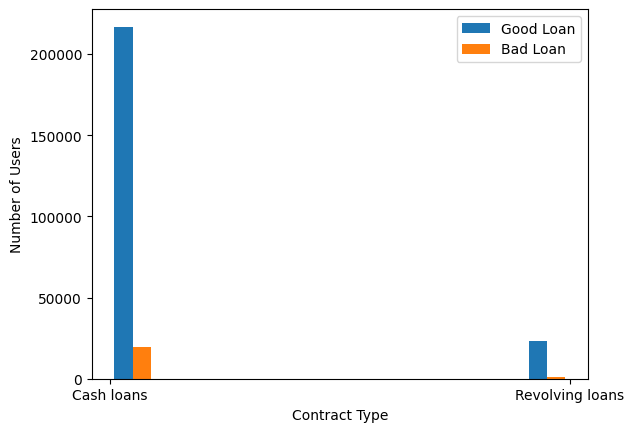

In [100]:
good_loan = train_flag_df[train_flag_df.TARGET == 0].NAME_CONTRACT_TYPE
bad_loan = train_flag_df[train_flag_df.TARGET == 1].NAME_CONTRACT_TYPE

plt.hist([good_loan, bad_loan], label=("Good Loan", "Bad Loan"))
plt.xlabel("Contract Type")
plt.ylabel("Number of Users")
plt.legend()

In [245]:
train_flag_df = pd.get_dummies(train_flag_df, columns = ['NAME_CONTRACT_TYPE'], prefix='type')

In [246]:
test_flag_df = pd.get_dummies(test_flag_df, columns = ['NAME_CONTRACT_TYPE'], prefix='type')

In [247]:
train_flag_df.head()

,uid,TARGET,type_Cash loans,type_Revolving loans
0,XDA69787158,0,1,0
1,BSE47789733,0,1,0
2,NTJ92213825,0,1,0
3,TCQ47571695,0,1,0
4,WJZ68772744,0,1,0


### For Enquiry dataframe

In [109]:
train_enquiry_df.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248


In [111]:
test_enquiry_df.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Car loan,143000,2020-12-13,AAA02107680
1,Real estate loan,174000,2020-12-01,AAA14437029
2,Loan for working capital replenishment,65000,2019-07-01,AAA14437029
3,Loan for working capital replenishment,118000,2020-08-05,AAA14437029
4,Car loan,12000,2020-02-28,AAA14437029


#### Checking for `Null` values

In [112]:
# For train dataset
train_enquiry_df.isnull().sum()

enquiry_type    0
enquiry_amt     0
enquiry_date    0
uid             0
dtype: int64

In [114]:
# For test dataset
test_enquiry_df.isnull().sum()

enquiry_type    0
enquiry_amt     0
enquiry_date    0
uid             0
dtype: int64

Hence, there are no null values in `enquiry` dataframe

#### Different type of loan enquiries 

In [115]:
train_enquiry_df.enquiry_type.unique()

array(['Interbank credit', 'Mobile operator loan',
       'Cash loan (non-earmarked)', 'Mortgage', 'Revolving loans',
       'Loan for purchase of shares (margin lending)', 'Cash loans',
       'Car loan', 'Another type of loan',
       'Loan for the purchase of equipment', 'Real estate loan',
       'Credit card', 'Unknown type of loan', 'Microloan',
       'Consumer credit', 'Loan for working capital replenishment',
       'Loan for business development'], dtype=object)

In [116]:
test_enquiry_df.enquiry_type.unique()

array(['Car loan', 'Real estate loan',
       'Loan for working capital replenishment', 'Unknown type of loan',
       'Loan for the purchase of equipment', 'Mortgage',
       'Another type of loan', 'Cash loan (non-earmarked)',
       'Loan for business development', 'Cash loans', 'Microloan',
       'Credit card', 'Consumer credit', 'Revolving loans',
       'Mobile operator loan', 'Interbank credit',
       'Loan for purchase of shares (margin lending)'], dtype=object)

In [120]:
set(train_enquiry_df.enquiry_type.unique()) == set(test_enquiry_df.enquiry_type.unique())

True

Hence, both train and test sets have same number of type of loans enquiries.

In [118]:
train_enquiry_df.enquiry_type.value_counts()

Cash loans                                      303108
Revolving loans                                 120181
Mobile operator loan                             99479
Real estate loan                                 99328
Microloan                                        99324
Unknown type of loan                             99280
Loan for purchase of shares (margin lending)     99230
Mortgage                                         99216
Credit card                                      99208
Another type of loan                             99154
Loan for the purchase of equipment               99152
Interbank credit                                 99063
Car loan                                         98994
Loan for business development                    98900
Cash loan (non-earmarked)                        98831
Loan for working capital replenishment           98814
Consumer credit                                  98664
Name: enquiry_type, dtype: int64

In [119]:
test_enquiry_df.enquiry_type.value_counts()

Cash loans                                      53125
Revolving loans                                 21168
Car loan                                        17894
Credit card                                     17701
Another type of loan                            17619
Real estate loan                                17618
Mobile operator loan                            17599
Microloan                                       17589
Loan for purchase of shares (margin lending)    17575
Unknown type of loan                            17524
Loan for business development                   17523
Loan for working capital replenishment          17511
Mortgage                                        17504
Cash loan (non-earmarked)                       17467
Loan for the purchase of equipment              17467
Interbank credit                                17393
Consumer credit                                 17385
Name: enquiry_type, dtype: int64

So most of the loan enquiries are for cash loans or revolving loans

In [ ]:
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]

<AxesSubplot: >

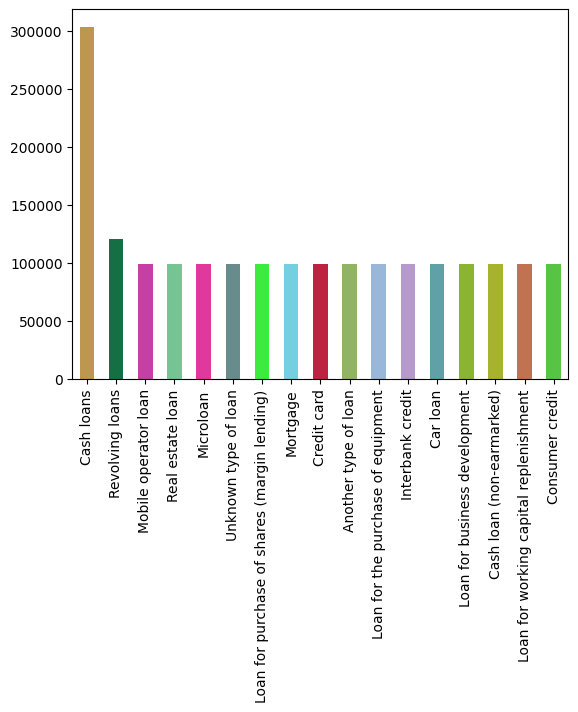

In [123]:
n = len(train_enquiry_df.enquiry_type.unique())
train_enquiry_df.enquiry_type.value_counts(dropna=False).plot(kind='bar', color=get_colors(n))

<AxesSubplot: >

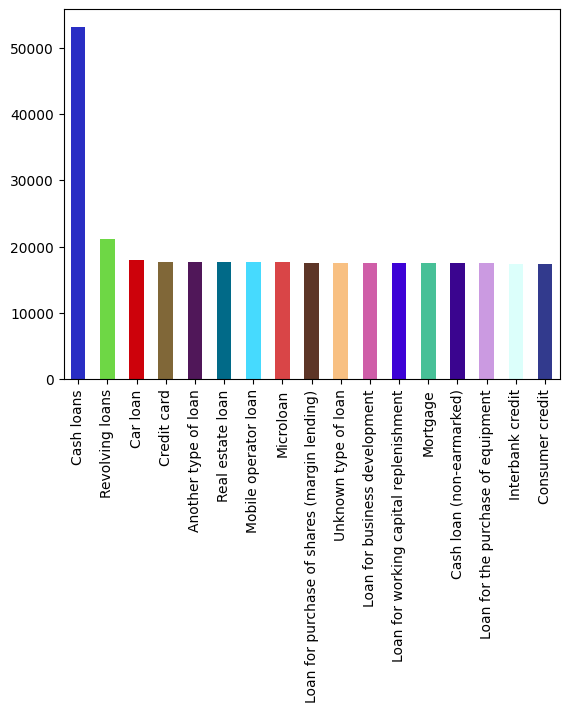

In [124]:
n = len(test_enquiry_df.enquiry_type.unique())
test_enquiry_df.enquiry_type.value_counts(dropna=False).plot(kind='bar', color=get_colors(n))

In [161]:
train_enquiry_df.enquiry_date = (pd.to_datetime(train_enquiry_df.enquiry_date) - datetime.datetime(1970,1,1)).dt.days

In [162]:
train_enquiry_df = pd.get_dummies(train_enquiry_df, columns = ['enquiry_type'], prefix='type')

In [164]:
test_enquiry_df.enquiry_date = (pd.to_datetime(test_enquiry_df.enquiry_date) - datetime.datetime(1970,1,1)).dt.days

In [165]:
test_enquiry_df = pd.get_dummies(test_enquiry_df, columns = ['enquiry_type'], prefix='type')

In [ ]:
scaler = MinMaxScaler()

In [304]:
train_enquiry_df[['enquiry_amt', 'enquiry_date']] = scaler.fit_transform(train_enquiry_df[['enquiry_amt', 'enquiry_date']])

In [305]:
test_enquiry_df[['enquiry_amt', 'enquiry_date']] = scaler.fit_transform(test_enquiry_df[['enquiry_amt', 'enquiry_date']])

In [306]:
train_enquiry_df.head()

,enquiry_amt,enquiry_date,uid,type_Another type of loan,type_Car loan,type_Cash loan (non-earmarked),type_Cash loans,type_Consumer credit,type_Credit card,type_Interbank credit,type_Loan for business development,type_Loan for purchase of shares (margin lending),type_Loan for the purchase of equipment,type_Loan for working capital replenishment,type_Microloan,type_Mobile operator loan,type_Mortgage,type_Real estate loan,type_Revolving loans,type_Unknown type of loan
0,0.336345,0.972322,AAA08065248,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0.535855,0.947207,AAA08065248,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0.070292,0.899539,AAA08065248,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.359648,0.776012,AAA08065248,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0.453823,0.886212,AAA08065248,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [307]:
test_enquiry_df.head()

,enquiry_amt,enquiry_date,uid,type_Another type of loan,type_Car loan,type_Cash loan (non-earmarked),type_Cash loans,type_Consumer credit,type_Credit card,type_Interbank credit,type_Loan for business development,type_Loan for purchase of shares (margin lending),type_Loan for the purchase of equipment,type_Loan for working capital replenishment,type_Microloan,type_Mobile operator loan,type_Mortgage,type_Real estate loan,type_Revolving loans,type_Unknown type of loan
0,0.284558,0.989883,AAA02107680,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.346690,0.983493,AAA14437029,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.128226,0.707135,AAA14437029,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0.234452,0.920660,AAA14437029,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0.022001,0.835996,AAA14437029,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### For Accounts dataframe

In [251]:
train_accounts_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915


In [252]:
test_accounts_df.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,31630.50,0.0,2014-03-30,2014-11-29,000000000000000000000000,AAA14437029
1,Consumer credit,14613.39,0.0,2014-06-01,2014-11-03,000000000000000,AAA14437029
2,Credit card,54000.00,0.0,2015-12-13,2019-09-21,0000000000000000000000000000000000000000000000...,AAA14437029
3,Consumer credit,27076.50,0.0,2015-11-11,2016-11-24,000000000000000000000000000000000000,AAA14437029
4,Credit card,225000.00,0.0,2017-07-15,2019-11-14,0000000000000000000000000000000000000000000000...,AAA14437029


In [253]:
train_accounts_df.credit_type.unique().size

15

In [254]:
# check for null values
train_accounts_df.isna().sum(axis=0)

credit_type                 0
loan_amount                 3
amount_overdue              0
open_date                   0
closed_date            463035
payment_hist_string         0
uid                         0
dtype: int64

In [255]:
# check for null values
test_accounts_df.isna().sum(axis=0)

credit_type                0
loan_amount                0
amount_overdue             0
open_date                  0
closed_date            81636
payment_hist_string        0
uid                        0
dtype: int64

In [256]:
# All rows with null values in loan_amount
train_accounts_df[train_accounts_df.loan_amount.isna()]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
65605,Another type of loan,NaN,0.0,2021-01-01,2020-10-21,,BJV01354901
149202,Another type of loan,NaN,0.0,2021-01-01,NaN,,DCX71532515
613183,Another type of loan,NaN,0.0,2021-01-01,NaN,,MVG95017452


In [257]:
# since the count of null values for loan amount in train_account_data is only three, 
# we can drop these three rows
indices = train_accounts_df[train_accounts_df.loan_amount.isna()].index
train_accounts_df.drop(labels=indices, inplace=True)

In [258]:
# check for null values
train_accounts_df.isna().sum(axis=0)

credit_type                 0
loan_amount                 0
amount_overdue              0
open_date                   0
closed_date            463033
payment_hist_string         0
uid                         0
dtype: int64

In [259]:
train_accounts_df.credit_type.value_counts()

Consumer credit                                 908741
Credit card                                     292422
Car loan                                         20237
Mortgage                                         13196
Microloan                                         7766
Loan for business development                     1466
Another type of loan                               729
Unknown type of loan                               374
Loan for working capital replenishment             320
Real estate loan                                    17
Cash loan (non-earmarked)                           17
Loan for the purchase of equipment                  16
Loan for purchase of shares (margin lending)         4
Interbank credit                                     1
Mobile operator loan                                 1
Name: credit_type, dtype: int64

<AxesSubplot: >

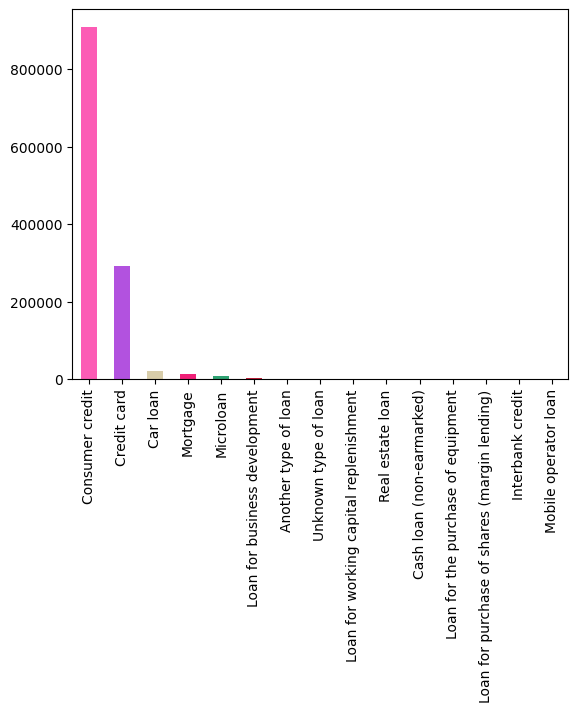

In [260]:
n = len(train_accounts_df.credit_type.unique())
train_accounts_df.credit_type.value_counts(dropna=False).plot(kind='bar', color=get_colors(n))

<AxesSubplot: >

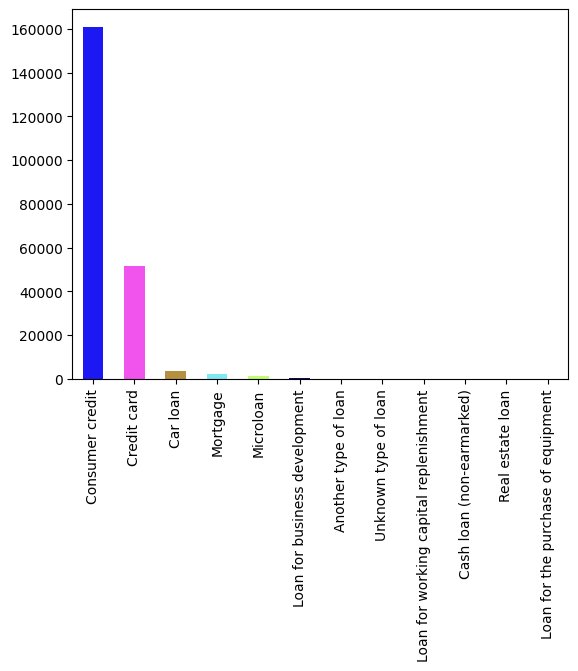

In [261]:
test_accounts_df.credit_type.value_counts(dropna=False).plot(kind='bar', color=get_colors(n))

So most of the loans are `Consumer credit` and `Credit card`

In [262]:
train_accounts_df.open_date = (pd.to_datetime(train_accounts_df.open_date) - datetime.datetime(1970,1,1)).dt.days

In [277]:
test_accounts_df.open_date = (pd.to_datetime(test_accounts_df.open_date) - datetime.datetime(1970,1,1)).dt.days

In [263]:
fn = lambda ele: 0 if pd.isna(ele) else 1
train_accounts_df.closed_date = train_accounts_df.closed_date.apply(fn) 

In [278]:
test_accounts_df.closed_date = test_accounts_df.closed_date.apply(fn) 

In [265]:
train_accounts_df = pd.get_dummies(train_accounts_df, columns = ['credit_type'], prefix='type')

In [279]:
test_accounts_df = pd.get_dummies(test_accounts_df, columns = ['credit_type'], prefix='type')

In [267]:
fn2 = lambda s: sum([s[i:i+3] != '000' for i in range(0, len(s), 3)])
train_accounts_df.payment_hist_string = train_accounts_df.payment_hist_string.apply(fn2)

In [280]:
test_accounts_df.payment_hist_string = test_accounts_df.payment_hist_string.apply(fn2)

In [ ]:
train_accounts_df['loan_amount', 'open_date', 'payment_hist_string'] 

In [297]:
scaler = MinMaxScaler()

In [299]:
train_accounts_df[['loan_amount', 'open_date', 'payment_hist_string']] = scaler.fit_transform(train_accounts_df[['loan_amount', 'open_date', 'payment_hist_string']])

In [ ]:
scaler = MinMaxScaler()

In [301]:
test_accounts_df[['loan_amount', 'open_date', 'payment_hist_string']] = scaler.fit_transform(test_accounts_df[['loan_amount', 'open_date', 'payment_hist_string']])

In [302]:
train_accounts_df.head()

,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,type_Another type of loan,type_Car loan,type_Cash loan (non-earmarked),type_Consumer credit,...,type_Interbank credit,type_Loan for business development,type_Loan for purchase of shares (margin lending),type_Loan for the purchase of equipment,type_Loan for working capital replenishment,type_Microloan,type_Mobile operator loan,type_Mortgage,type_Real estate loan,type_Unknown type of loan
0,0.000689,0.0,0.715264,1,0.012346,AAA09044550,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.000011,0.0,0.647502,1,0.024691,AAA09044550,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.000205,0.0,0.936345,0,0.000000,AAA10545297,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000111,0.0,0.929500,1,0.000000,AAA14112888,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.000026,0.0,0.211157,0,0.382716,AAA20326915,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [303]:
test_accounts_df.head()

,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,type_Another type of loan,type_Car loan,type_Cash loan (non-earmarked),type_Consumer credit,type_Credit card,type_Loan for business development,type_Loan for the purchase of equipment,type_Loan for working capital replenishment,type_Microloan,type_Mortgage,type_Real estate loan,type_Unknown type of loan
0,0.000545,0.0,0.155084,1,0.00000,AAA14437029,0,0,0,1,0,0,0,0,0,0,0,0
1,0.000252,0.0,0.176652,1,0.00000,AAA14437029,0,0,0,1,0,0,0,0,0,0,0,0
2,0.000931,0.0,0.368367,1,0.00000,AAA14437029,0,0,0,0,1,0,0,0,0,0,0,0
3,0.000467,0.0,0.357412,1,0.00000,AAA14437029,0,0,0,1,0,0,0,0,0,0,0,0
4,0.003877,0.0,0.566929,1,0.15873,AAA14437029,0,0,0,0,1,0,0,0,0,0,0,0


### Joining Dataframes

In [344]:
train_accounts_df.columns

Index(['loan_amount', 'amount_overdue', 'open_date', 'closed_date',
       'payment_hist_string', 'uid', 'type_Another type of loan',
       'type_Car loan', 'type_Cash loan (non-earmarked)',
       'type_Consumer credit', 'type_Credit card', 'type_Interbank credit',
       'type_Loan for business development',
       'type_Loan for purchase of shares (margin lending)',
       'type_Loan for the purchase of equipment',
       'type_Loan for working capital replenishment', 'type_Microloan',
       'type_Mobile operator loan', 'type_Mortgage', 'type_Real estate loan',
       'type_Unknown type of loan'],
      dtype='object')

In [345]:
test_accounts_df.columns

Index(['loan_amount', 'amount_overdue', 'open_date', 'closed_date',
       'payment_hist_string', 'uid', 'type_Another type of loan',
       'type_Car loan', 'type_Cash loan (non-earmarked)',
       'type_Consumer credit', 'type_Credit card',
       'type_Loan for business development',
       'type_Loan for the purchase of equipment',
       'type_Loan for working capital replenishment', 'type_Microloan',
       'type_Mortgage', 'type_Real estate loan', 'type_Unknown type of loan'],
      dtype='object')

In [347]:
train_accounts_df.drop(['type_Interbank credit', 'type_Loan for purchase of shares (margin lending)', 'type_Mobile operator loan'], axis= 1, inplace=True)

In [349]:
train_df1 = pd.merge(train_enquiry_df, train_accounts_df, how='inner', on='uid')

In [350]:
train_final = pd.merge(train_df1, train_flag_df, how = 'inner', on='uid')

In [351]:
train_final.head()

,enquiry_amt,enquiry_date,uid,type_Another type of loan_x,type_Car loan_x,type_Cash loan (non-earmarked)_x,type_Cash loans_x,type_Consumer credit_x,type_Credit card_x,type_Interbank credit,...,type_Loan for business development_y,type_Loan for the purchase of equipment_y,type_Loan for working capital replenishment_y,type_Microloan_y,type_Mortgage_y,type_Real estate loan_y,type_Unknown type of loan_y,TARGET,type_Cash loans_y,type_Revolving loans_y
0,0.238469,0.743209,AAA09044550,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.238469,0.743209,AAA09044550,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.392781,0.781138,AAA09044550,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0.392781,0.781138,AAA09044550,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0.252497,0.900564,AAA09044550,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [354]:
test_df1 = pd.merge(test_enquiry_df, test_accounts_df, how='inner', on='uid')

In [355]:
test_final = pd.merge(test_df1, test_flag_df, how = 'inner', on='uid')

In [356]:
test_final.head()

,enquiry_amt,enquiry_date,uid,type_Another type of loan_x,type_Car loan_x,type_Cash loan (non-earmarked)_x,type_Cash loans_x,type_Consumer credit_x,type_Credit card_x,type_Interbank credit,...,type_Credit card_y,type_Loan for business development_y,type_Loan for the purchase of equipment_y,type_Loan for working capital replenishment_y,type_Microloan_y,type_Mortgage_y,type_Real estate loan_y,type_Unknown type of loan_y,type_Cash loans_y,type_Revolving loans_y
0,0.34669,0.983493,AAA14437029,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.34669,0.983493,AAA14437029,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.34669,0.983493,AAA14437029,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,0.34669,0.983493,AAA14437029,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.34669,0.983493,AAA14437029,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [352]:
y = train_final.pop('TARGET')

In [353]:
train_uid = train_final.pop('uid')

In [357]:
test_uid = test_final.pop('uid')

In [358]:
clf = RandomForestClassifier(max_depth=2, random_state=2)

In [359]:
clf.fit(train_final, y)

RandomForestClassifier(max_depth=2, random_state=2)

In [364]:
test_preds = clf.predict(test_final)

In [368]:
test_preds = pd.Series(test_preds)

In [369]:
final_data = {'uid': test_uid, 'pred': test_preds}

In [370]:
final_df = pd.concat(final_data, axis=1)

In [375]:
final_df.to_csv('data/final_submission/anurag_agarwal.csv', index=False)